In [1]:
import zipfile
import os
from google.colab import drive

# Authenticate and mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# Specify the zip file paths
zip_path_clear = '/content/drive/MyDrive/Clear_Images-20240808T071449Z-001.zip'  # Replace with your own first zip file path in Google Colab
zip_path_hazy = '/content/drive/MyDrive/Hazy_Images-20240808T071517Z-001.zip'  # Replace with your own second zip file path in Google Colab

In [3]:
# Specify the destination folder names for extracted images
extract_path_clear = '/content/drive/My Drive/Clear_Images'
extract_path_hazy = '/content/drive/My Drive/Hazy_Images'

In [4]:
# Create extraction folders if they don't exist
import os
os.makedirs(extract_path_clear, exist_ok=True)
os.makedirs(extract_path_hazy, exist_ok=True)

In [5]:
# Extract clear_imgs.zip
with zipfile.ZipFile(zip_path_clear, 'r') as zip_ref:
    zip_ref.extractall(extract_path_clear)

In [7]:
try:
    with zipfile.ZipFile(zip_path_hazy, 'r') as zip_ref_hazy:
        zip_ref_hazy.extractall(extract_path_hazy)
    print("Hazy images extracted successfully.")
except Exception as e:
    print(f"Error extracting hazy images: {e}")

Hazy images extracted successfully.


In [8]:
import os

clear_images_path = '/content/drive/MyDrive/Clear_Images'
hazy_images_path = '/content/drive/MyDrive/Hazy_Images'

def sort_images_in_folder(folder_path):
    images = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
    images.sort(key=lambda x: int(os.path.splitext(x)[0]))
    for idx, image in enumerate(images, start=1):
        old_image_path = os.path.join(folder_path, image)
        new_image_path = os.path.join(folder_path, f"{idx:04d}.tif")  # Adjust the format as needed
        if old_image_path != new_image_path:
            os.rename(old_image_path, new_image_path)

sort_images_in_folder(clear_images_path)
sort_images_in_folder(hazy_images_path)

In [9]:
import os

clear_images_path = '/content/drive/MyDrive/Clear_Images/Clear_Images/Clear_imgs'
hazy_images_path = '/content/drive/MyDrive/Hazy_Images/Hazy_Images/Hazy_img'

def count_images_in_folder(folder_path):
    images = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
    return len(images)

clear_images_count = count_images_in_folder(clear_images_path)
hazy_images_count = count_images_in_folder(hazy_images_path)

print(f"Number of images in Clear_Images folder: {clear_images_count}")
print(f"Number of images in Hazy_Images folder: {hazy_images_count}")

Number of images in Clear_Images folder: 224
Number of images in Hazy_Images folder: 224


In [12]:
!pip install --upgrade scikit-image  # Upgrade scikit-image to the latest version
!pip install imagecodecs  # Install the imagecodecs module

import os
from PIL import Image
from skimage import img_as_ubyte
from skimage.filters import gaussian
from imagecodecs import imread # Now this import should work
import os
from PIL import Image
from skimage import img_as_ubyte
from skimage.filters import gaussian
from imagecodecs import imread

# Function for preprocessing images
def preprocess_images(input_folder, output_folder):
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith('.tif'):
                input_image_path = os.path.join(root, file)
                relative_folder_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_folder_path)
                os.makedirs(output_subfolder, exist_ok=True)

                img = imread(input_image_path)
                # Apply preprocessing techniques here, e.g., noise removal
                if img.ndim == 3:  # Check if the image is multichannel
                    img_processed = gaussian(img, sigma=1, channel_axis=-1)  # Apply Gaussian filter along the channel axis
                else:
                    img_processed = gaussian(img, sigma=1)  # Apply Gaussian filter to a single-channel image
                img_processed = img_as_ubyte(img_processed)  # Convert image to 8-bit
                # Save preprocessed image
                output_image_path = os.path.join(output_subfolder, file)
                Image.fromarray(img_processed).save(output_image_path)

# Path to the input and output folders
clear_images_input_folder = '/content/drive/MyDrive/Clear_Images/Clear_Images'
hazy_images_input_folder = '/content/drive/MyDrive/Hazy_Images/Hazy_Images'
clear_images_output_folder = '/content/drive/My Drive/Preprocessed_Clear_Images'
hazy_images_output_folder = '/content/drive/My Drive/Preprocessed_Hazy_Images'

# Preprocess clear images
preprocess_images(clear_images_input_folder, clear_images_output_folder)

# Preprocess hazy images
preprocess_images(hazy_images_input_folder, hazy_images_output_folder)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 35.0 MB/s eta 0:00:00


In [13]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the DenseNet block
def densenet_block(inputs, growth_rate):
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv2D(4 * growth_rate, 1, padding='same')(x)  # Bottleneck layer (1x1 Conv)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(growth_rate, 3, padding='same')(x)  # 3x3 Conv layer

    x = Concatenate()([inputs, x])
    return x

# Define the DenseNet model
def densenet_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, 3, padding='same')(inputs)  # Initial Conv Layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # DenseNet blocks
    for i in range(5):
        x = densenet_block(x, growth_rate=16)  # Adjust the growth rate as needed

    x = Conv2D(3, 3, padding='same')(x)  # Final Conv Layer
    outputs = Activation('sigmoid')(x)  # Sigmoid activation for normalized output

    model = Model(inputs=inputs, outputs=outputs)
    return model




In [14]:
#5
import os
import numpy as np
from PIL import Image

def data_generator(hazy_dir, clear_dir, batch_size):
    while True:
        hazy_images = []
        clear_images = []
        for i in range(66, 290):
            filename = str(i) + '.tif'
            img = Image.open(os.path.join(hazy_dir, filename))
            hazy_images.append(np.array(img))
            clear_filename = str(i) + '.tif'
            clear_img = Image.open(os.path.join(clear_dir, clear_filename))
            clear_images.append(np.array(clear_img))
            if len(hazy_images) == batch_size:
                X = np.array(hazy_images) / 255.0
                y = np.array(clear_images) / 255.0
                yield X, y
                hazy_images = []
                clear_images = []

In [15]:
#6
# Set the directories and batch size
hazy_dir = '/content/drive/MyDrive/Preprocessed_Hazy_Images/Hazy_img'
clear_dir = '/content/drive/MyDrive/Preprocessed_Clear_Images/Clear_imgs'
batch_size = 8

# Get the list of file names in the directories
hazy_filenames = os.listdir(hazy_dir)
clear_filenames = [os.path.splitext(filename)[0] + '_clear.tif' for filename in hazy_filenames]

# Split the file names into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    hazy_filenames, clear_filenames, test_size=0.2, random_state=42)

In [16]:
#7
import os

folder_path1 = "/content/drive/MyDrive/Preprocessed_Hazy_Images/Hazy_img" # Replace with the path to your folder
num_images1 = len(os.listdir(folder_path1))
print("Number of images in folder:", num_images1)

folder_path2 = "/content/drive/MyDrive/Preprocessed_Clear_Images/Clear_imgs" # Replace with the path to your folder
num_images2 = len(os.listdir(folder_path2))
print("Number of images in folder:", num_images2)

Number of images in folder: 224
Number of images in folder: 224


In [17]:
#8
from sklearn.model_selection import train_test_split

#Split the file names into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    hazy_filenames, clear_filenames, test_size=0.2, random_state=42)

In [18]:
#9
# Define data generators
train_generator = data_generator(hazy_dir, clear_dir, batch_size=batch_size)
test_generator = data_generator(hazy_dir, clear_dir, batch_size=batch_size)

In [19]:
#10
# Build the model
model = densenet_model(input_shape=(None, None, 3))

In [20]:
#11
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
#12
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU available:", True)
    print("CUDA version:", gpu_devices[0].name)
else:
    print("GPU available:", False)

TensorFlow version: 2.17.0
GPU available: True
CUDA version: /physical_device:GPU:0


In [22]:
#13

import matplotlib.pyplot as plt

# Train the model and collect the loss and accuracy data
history = model.fit(train_generator, epochs=100, steps_per_epoch=len(X_train) // batch_size,
          validation_data=test_generator, validation_steps=len(X_test) // batch_size)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 66s 866ms/step - loss: 0.0311 - val_loss: 0.0589
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 813ms/step - loss: 0.0093 - val_loss: 0.0445
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 842ms/step - loss: 0.0063 - val_loss: 0.0410
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 821ms/step - loss: 0.0054 - val_loss: 0.0456
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 831ms/step - loss: 0.0041 - val_loss: 0.0279
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 848ms/step - loss: 0.0054 - val_loss: 0.0296
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 848ms/step - loss: 0.0053 - val_loss: 0.0259
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 835ms/step - loss: 0.0047 - val_loss: 0.0234
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 839ms/step - loss: 0.0041 - val_loss: 0.0301
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 842ms/step - loss: 0.0044 - val_loss: 0.0251
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 837ms/step - loss: 0.0047 - val_loss: 0.0254
Epoch 12/100
22/22 ━━━━━━━━━━━

In [23]:
#14
# Save the model
#14
# Save the model
model.save('/content/drive/MyDrive/dehaze_model.keras') # Change the file extension to .keras or .h5

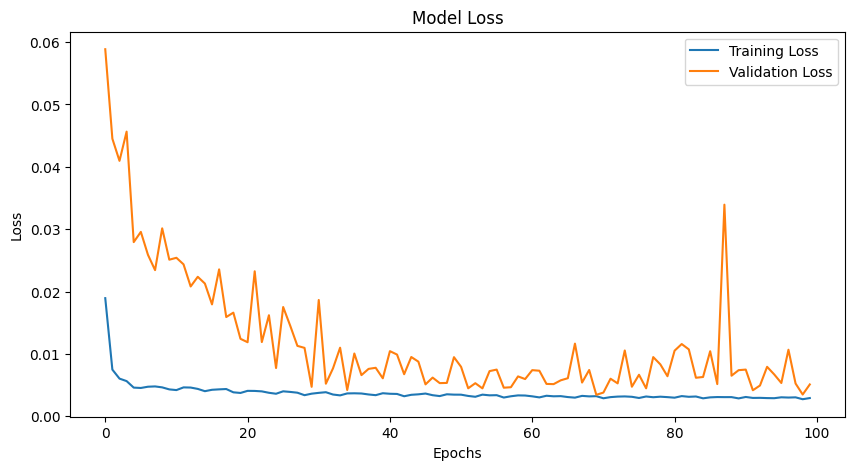

In [24]:
# Create subplots to visualize the loss and accuracy data
fig, (ax1) = plt.subplots(1, figsize=(10, 5))

# Plot the training and validation loss data
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


In [25]:
#15
train_loss = model.evaluate(train_generator, steps=len(X_train) // batch_size)
print('Train loss:', train_loss)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - loss: 0.0052
Train loss: 0.005055718589574099


In [26]:
#16
# Evaluate the model on the test set
mse = model.evaluate(test_generator, steps=len(X_test)//batch_size)
print("Mean Squared Error on Test Set:", mse)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.0048
Mean Squared Error on Test Set: 0.0049392422661185265


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


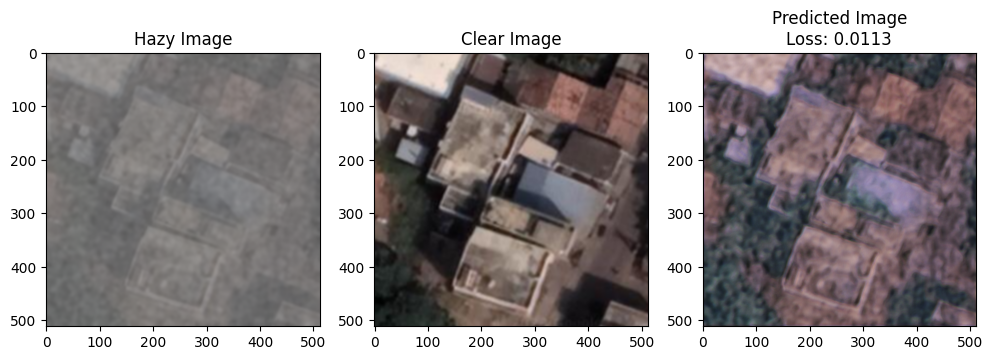

In [27]:
#17
import os
from matplotlib import pyplot as plt
from PIL import Image
# Select an image index to evaluate
idx = 0
hazy_dir = '/content/drive/MyDrive/Preprocessed_Hazy_Images/Hazy_img'
clear_dir = '/content/drive/MyDrive/Preprocessed_Clear_Images/Clear_imgs'
batch_size = 8
# Load the hazy and clear images

hazy_image = Image.open(os.path.join(hazy_dir, '/content/drive/MyDrive/Preprocessed_Hazy_Images/Hazy_img/163.tif'))
clear_image = Image.open(os.path.join(clear_dir, '/content/drive/MyDrive/Preprocessed_Clear_Images/Clear_imgs/163.tif'))
# Generate a prediction for the hazy image
hazy_array = np.array(hazy_image) / 255.0
hazy_array = np.expand_dims(hazy_array, axis=0)

#model = load_model('/content/drive/MyDrive/dehaze_model.h1')
predicted_array = model.predict(hazy_array)[0]
predicted_image = Image.fromarray(np.uint8(predicted_array*255))


clear_array = np.array(clear_image) / 255.0

loss = np.mean(np.square(clear_array - predicted_array))

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(hazy_image)
ax[0].set_title('Hazy Image')
ax[1].imshow(clear_image)
ax[1].set_title('Clear Image')
ax[2].imshow(predicted_image)
ax[2].set_title(f'Predicted Image\nLoss: {loss:.4f}')
plt.show()

In [28]:
model1 = densenet_model(input_shape=(None, None, 3))
model1.load_weights('/content/drive/MyDrive/dehaze_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


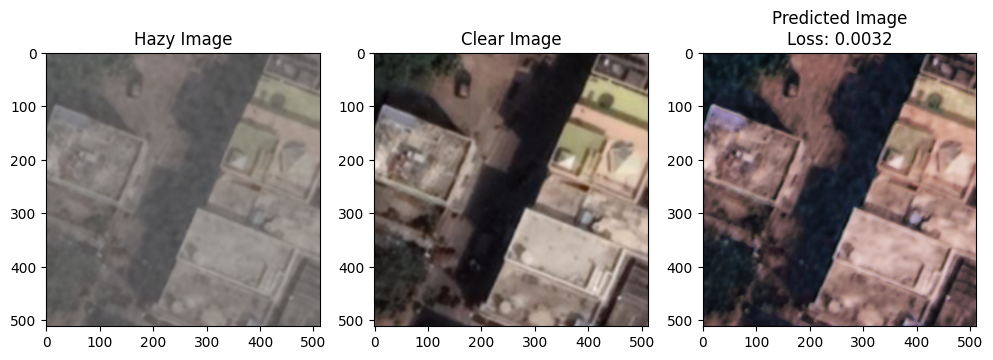

In [29]:
#17
import os
from matplotlib import pyplot as plt
from PIL import Image
# Select an image index to evaluate
idx = 0
hazy_dir = '/content/drive/MyDrive/Preprocessed_Hazy_Images/Hazy_img'
clear_dir = '/content/drive/MyDrive/Preprocessed_Clear_Images/Clear_imgs'
batch_size = 8
# Load the hazy and clear images

hazy_image = Image.open(os.path.join(hazy_dir, '/content/drive/MyDrive/Preprocessed_Hazy_Images/Hazy_img/164.tif'))
clear_image = Image.open(os.path.join(clear_dir, '/content/drive/MyDrive/Preprocessed_Clear_Images/Clear_imgs/164.tif'))
# Generate a prediction for the hazy image
hazy_array = np.array(hazy_image) / 255.0
hazy_array = np.expand_dims(hazy_array, axis=0)

#model = load_model('/content/drive/MyDrive/dehaze_model.h1')
predicted_array = model1.predict(hazy_array)[0]
predicted_image = Image.fromarray(np.uint8(predicted_array*255))


clear_array = np.array(clear_image) / 255.0

loss = np.mean(np.square(clear_array - predicted_array))

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(hazy_image)
ax[0].set_title('Hazy Image')
ax[1].imshow(clear_image)
ax[1].set_title('Clear Image')
ax[2].imshow(predicted_image)
ax[2].set_title(f'Predicted Image\nLoss: {loss:.4f}')
plt.show()

In [30]:
#14
# Save the model
model.save('/content/drive/MyDrive/dehaze_model.keras')

In [31]:
model1_45 = densenet_model(input_shape=(None, None, 3))
model1_45.load_weights('/content/drive/MyDrive/dehaze_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


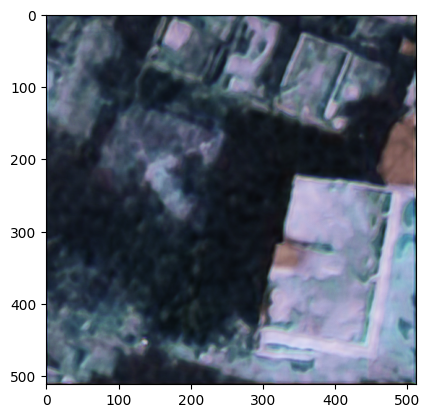

In [32]:
#18
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model


# Load hazy image
hazy_img = cv2.imread('/content/drive/MyDrive/Preprocessed_Hazy_Images/Hazy_img/165.tif')

# Preprocess the hazy image
hazy_img = hazy_img / 255.0
hazy_img = np.expand_dims(hazy_img, axis=0)

# Apply the dehazing model to the hazy image
dehazed_img = model1.predict(hazy_img)[0]

# Display the dehazed image using matplotlib
plt.imshow(dehazed_img)
plt.show()


In [33]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Load the hazy and clear images
hazy_image = Image.open(os.path.join(hazy_dir, '152.tif'))
clear_image = Image.open(os.path.join(clear_dir, '152.tif'))

# Resize the hazy image to the same dimensions as the clear image
hazy_image_resized = hazy_image.resize(clear_image.size)

# Convert images to numpy arrays
hazy_array_resized = np.array(hazy_image_resized) / 255.0
clear_array = np.array(clear_image) / 255.0

# Ensure that both arrays have the same dtype
hazy_array_resized = hazy_array_resized.astype(np.float32)
clear_array = clear_array.astype(np.float32)

# Generate a prediction for the resized hazy image
predicted_array = model.predict(np.expand_dims(hazy_array_resized, axis=0))[0]

# Calculate PSNR and SSIM
psnr_value = psnr(clear_array, predicted_array, data_range=1.0)
ssim_value = ssim(clear_array, predicted_array, data_range=1.0, channel_axis=-1)

print("Peak Signal-to-Noise Ratio (PSNR):", psnr_value)
print("Structural Similarity Index (SSIM):", ssim_value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Peak Signal-to-Noise Ratio (PSNR): 24.531951487750966
Structural Similarity Index (SSIM): 0.81032664
